# Практика №2

На прошлой практике мы реализовали DTW алгоритм. Он очень хорош и вроде как даже где-то применяется. Но у него есть существенные недостатки:

1. Для распознавания какого-либо слова необходимо иметь заранее подготовленные эталонные записи. Из этого вытекает проблема масштабирования системы с большим словарем.
2. Подобная система имеет плохую устойчивость к шумам.
3. По какому принципу вибирать нужные эталоны?
4. Сколько должно быть таких эталонов, чтобы покрыть всю вариативность произнесений?
5. Чем больше эталонов, тем алгоритм вычислительнозатратен.

В этом уроке мы перейдем от DTW к распознаванию по эталонному словарю. 

Эталон в графе теперь будет задаваться как последовательность фонем из словаря. Словарь для YES_NO (data/lexicon_yes_no.txt) выглядит следующим образом:
* **YES**: SIL Y EH1 S SIL
* **NO**: SIL N OW1 SIL

Словарь для цифр (data/lexicon_digits.txt):
* **ZERO**: SIL Z IH1 R OW0 SIL
* **ZERO**: SIL Z IY1 R OW0 SIL
* **ONE**: SIL W AH1 N SIL
* **ONE**: SIL HH W AH1 N SIL
* **TWO**: SIL T UW1 SIL
* **THREE**: SIL TH R IY1 SIL
* **FOUR**: SIL F AO1 R SIL
* **FIVE**: SIL F AY1 V SIL
* **SIX**: SIL S IH1 K S SIL
* **SEVEN**: SIL S EH1 V AH0 N SIL
* **EIGHT**: SIL EY1 T SIL
* **NINE**: SIL N AY1 N SIL

SIL здесь – это фонема паузы.
Как вы, возможно, заметили, для некторых слов имеется несколько вариантов фонемной транскрипции. Это позволяет лучше учесть фонетическое разнообразие в произнесении некоторых слов.

Каждой фонеме будет сопоставлен наиболее типичный для неё вектор признаков. В данном случае мы будем использовать среднее значение вектора признаков фонем, взятых из обучающего набора. Будем называть это акустической моделью.

### Данные для обучения

Наша задача — собрать статистику акустических признаков по каждой фонеме, находящейся в графе распознавания. В качестве обучающей выборки мы будем использовать подмножество данных `librispeech` (аудиозаписи чтения книг на английском). Для этого предварительно была получена покадровая разметка этого подмножества на фонемы. Схематично данный процесс представлен на картинке ниже:

![](https://drive.google.com/uc?export=view&id=16PdwggV_Cl6aaD4cu1MZ-fKzWzAvcFVw)

Файл разметки (ali_phones.txt) представлен в формате:

<b>filename1 phone_frame1 phone_frame2 phone_frame3 ...**<br>
**filename2 phone_frame1 phone_frame2 phone_frame3 ...</b>

Пример такой покадровой фонемной разметки одного файла с текстом "<b>MUCH COULD BE DONE IN THREE YEARS</b>" представлен ниже:

<b>1183-124566-0003 SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL M M M M M M M M M AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 CH CH CH CH CH CH CH CH CH CH CH K K K K K K K K K UH1 UH1 UH1 UH1 D D D D D B B B B B B IY0 IY0 IY0 IY0 IY0 D D D D D D D D D D D D AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 N N N N N N N N N N N N N N N SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SI L SIL SIL SIL SIL SIL SIL SIL SIL IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 N N N N N N N N N N SIL SIL SIL SIL SIL TH TH TH TH TH TH TH TH TH TH TH TH TH R R R R R R IY1 IY1 IY1 IY1 IY1 IY1 IY1 Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 R R R R R R R R R R R R R R R Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z SIL SIL SIL SIL</b>

Аудиофайлы этих данных лежат в папке "data/train_librispeech_10h/wav_dir".

### Bootstrap

In [ ]:
!rm -rf lab2

In [ ]:
!gdown --id "1meikF0XqBUnVZKoY3160MQ0R25lq-EMu"
!unzip -nq lab2.zip

Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 98.9MB/s]


In [ ]:
!gdown --id "1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox"
!unzip -nq train_librispeech_10h.zip

Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
679MB [00:04, 148MB/s]


In [ ]:
!mv train_librispeech_10h lab2/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab2

/content/lab2


In [ ]:
import os
import time

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import IPython.display as ipd
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["image.interpolation"] = "nearest"

In [ ]:
# Sample example:
wav_example = "data/train_librispeech_10h/wav_dir/1183-124566-0003.flac"

# Read wav file.
# sr=None to preserve the native sampling rate.
x, sr = librosa.load(wav_example, sr=None)

print(f"Number of samples: {len(x)}.")
print(f"Sampling rate: {sr} Hz.")
print(f"Duration: {len(x) / sr:.2f} s.")  # ~ librosa.get_duration(x, sr)

# Playback:
ipd.Audio(x, rate=sr)

Number of samples: 45680.
Sampling rate: 16000 Hz.
Duration: 2.85 s.


Text(0.5, 1.0, 'Log-frequency power spectrogram')

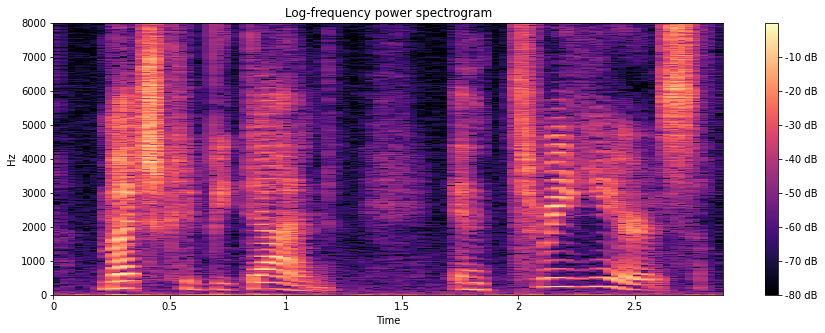

In [ ]:
# Spectrogram:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
librosa.display.specshow(D, sr=sr, y_axis="hz", x_axis="time")
plt.colorbar(format="%+2.0f dB")
plt.title("Log-frequency power spectrogram")

### Подготовка данных

In [ ]:
# Загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding="utf-8") as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = "data/train_librispeech_10h/ali_phones.txt"
ali_dict = load_phone_aligment(ali_file)

In [ ]:
# Подсчёт акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f"Early stop at {step}th file.")
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

train_records_dir = "data/train_librispeech_10h/wav_dir"
train_data_dict = load_data_dict(train_records_dir, count=100)

Early stop at 100th file.


In [ ]:
# Инициализация списка допустимых фонем из предустановленного файла:
def init_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding="utf-8") as fn:
        for line in fn:
            phones_dict[line.strip()] = []
    return phones_dict

phones_file = "data/train_librispeech_10h/phones"
phones_dict = init_phones_dict(phones_file)

In [ ]:
# Присвоим каждой фонеме набор её признаков в соответствии с фонемной разметкой
# обучающей выборки. Количество кадров признаков может немного отличаться
# от количества размеченных фонем; это связано с особенностми построения
# разметки в Kaldi.
for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])

# Выведем статистику по каждой фонеме (некоторые фонемы вообще не используются,
# это особенности разметки в Kaldi):
count = 0
for phone in phones_dict.keys():
    if len(phones_dict[phone]) == 0:
        count +=1
    print(f"{phone:<3}: {len(phones_dict[phone])}")
print(f"Number of empty phones is: {count}.")

SIL: 23107
SPN: 583
AA : 0
AA0: 25
AA1: 2133
AA2: 105
AE : 0
AE0: 72
AE1: 3503
AE2: 101
AH : 0
AH0: 5858
AH1: 2061
AH2: 34
AO : 0
AO0: 16
AO1: 2183
AO2: 59
AW : 0
AW0: 10
AW1: 943
AW2: 33
AY : 0
AY0: 8
AY1: 3300
AY2: 260
B  : 1590
CH : 795
D  : 3987
DH : 2043
EH : 0
EH0: 48
EH1: 2980
EH2: 143
ER : 0
ER0: 2605
ER1: 1069
ER2: 11
EY : 0
EY0: 55
EY1: 2172
EY2: 82
F  : 2799
G  : 793
HH : 2100
IH : 0
IH0: 2647
IH1: 2343
IH2: 95
IY : 0
IY0: 2397
IY1: 2239
IY2: 99
JH : 740
K  : 3306
L  : 4308
M  : 3009
N  : 6267
NG : 1366
OW : 0
OW0: 182
OW1: 2179
OW2: 81
OY : 0
OY0: 0
OY1: 433
OY2: 0
P  : 2314
R  : 4474
S  : 7244
SH : 1446
T  : 6528
TH : 799
UH : 0
UH0: 0
UH1: 443
UH2: 6
UW : 0
UW0: 93
UW1: 1706
UW2: 43
V  : 1755
W  : 2391
Y  : 766
Z  : 3481
ZH : 66
Number of empty phones is: 18.


In [ ]:
# Соберём статистику на основе среднего значения для каждой фонемы:
mean_phones_value = {}
for phone in phones_dict.keys():
    if phones_dict[phone]:
        mean_phones_value[phone] = np.mean(phones_dict[phone], axis=0)

In [ ]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание 2)
#-----------------------------------------------------------------------

### Инициализация фонемного графа

In [ ]:
# Теперь будем распознавать по словарю, состоящему из конечных слов.
# Для этого нужно загрузить файл лексикона, который определяет,
# из каких фонем состоят наши слова:
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding="utf-8") as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

lexicon_file = "data/lexicon_yes_no.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)

Узлы графа теперь представляют собой отдельные фонемы с переходом только в себя и следующий узел (переходов через несколько узлов уже не будет, так как пропуск фонемы в слове нежелателен). Схема такого графа для да/нет (для цифр по аналогии) представлена ниже:

![](https://drive.google.com/uc?export=view&id=1IJhR0l0YCPDge05ohigs0_P5gDX66fdM)

В качестве <b>model</b> мы будем хранить простой класс <b>AcousticModel</b>, который хранит в себе имя фонемы и ее среднее значение. Также у этого класса есть метод вычисления евклидовой дистанции от хранящегося в нем среднего значения признака фонемы до текущего признака распознаваемой записи, который передается этому методу. 

In [ ]:
class AcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats

    def distance(self, input_feats):
        return float(np.sqrt(sum(pow(self.phone_feats - input_feats, 2))))

#-----------------------------TODO №2------------------------------------------
# Заменить акустическую модель на основе среднего значения признака
# на GMM модель:
class GmmAcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        if not phone_feats:
            self.phone_feats = None
        elif len(phone_feats) == 1:
            self.phone_feats = GaussianMixture(1).fit(phone_feats)
        else:
            self.phone_feats = GaussianMixture(3).fit(phone_feats)

    def distance(self, input_feats):
        input_feats = np.asarray(input_feats).reshape(1, -1)
        return -self.phone_feats.score(input_feats)
#------------------------------------------------------------------------------


class State:
    def __init__(self, model, index):
        # model: node feature vector
        # is_final: whether the node is final in the word
        # word: etalon word (only present for the final node)
        # best_token: token with the least distance in the node
        # current_word: current etalon word
        # next_states: the list of next nodes
        # index: node index
        self.model = model
        self.is_final = False
        self.word = None
        self.best_token = None
        self.current_word = None
        self.next_states = []
        self.index = index


def load_graph(lexicon_dict, mean_phones_value):
    start_state = State(AcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, mean_phones_value[phone]),
                          state_index)
            # Etalon word will now be stored in each node:
            state.current_word = word
            state.next_states.append(state)  # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    if not os.path.exists("exp"):
        os.mkdir("exp")
    with open("exp/graph.txt", "w") as fn:
        np.set_printoptions(formatter={"float": "{: 0.1f}".format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write(
                "State: index={} word={} is_final={} " \
                "next_state_indexes={} phone={} \n".format(
                    state.index, state.word, state.is_final,
                    next_state_indexes, state.model.phone_name
                )
            )
    print("*** SEE exp/graph.txt ***")

In [ ]:
graph = load_graph(lexicon_dict, mean_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [ ]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        # state: graph state that the given token has at the moment
        # dist: total accumulated distance traveled by the token
        # word: the word that was recognized by the token
        # alive: whether the token is alive
        self.state = state
        self.dist = dist
        self.word = word
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    best_token = next_tokens[np.argmin([token.dist for token in next_tokens])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False              
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens


def recognize(filename, features, graph, recognition_results, beam_threshold):
    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    # for ftr_frame in tqdm(features, desc="recognition..."):
    for ftr_frame in features:
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame)
                    next_tokens.append(new_token)
        # State and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    

    # Поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[
            np.argmin([token.dist for token in final_tokens])
        ]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[
            np.argmin([token.dist for token in alive_tokens])
        ]
        win_token.state.word = win_token.state.current_word

    # Вывод результата DTW:
    print(f"Result: {filename:<27} ==> {win_token.state.word}.")

    # Совпадает ли запись с полученным эталоном:
    record_word = filename.split("_")[0]
    etalon_word = win_token.state.word.split("_")[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [ ]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename, records_data_dict[filename],
                                        graph, recognition_results,
                                        beam_threshold)

    print("-" * 60)
    wer = (1 - sum(recognition_results) / len(recognition_results)) * 100
    total_time = time.time() - start_time
    print(f"WER is: {wer:.2f}%.")
    print(f"Total time is: {total_time:.2f} sec.")
    print("-" * 60)
    return wer, total_time

In [ ]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T

    return data_dict

### Запустим наше распознавание на базе YES_NO

In [ ]:
lexicon_file = "data/lexicon_yes_no.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("data/yes_no/records")

In [ ]:
wer_yes_no_mean, time_yes_no_mean = run_recognizer(records_data_dict,
                                                   graph, beam_threshold=5)

Result: yes_39a6b995_nohash_0.wav   ==> NO.
Result: no_4abb2400_nohash_0.wav    ==> NO.
Result: no_ad89eb1e_nohash_0.wav    ==> NO.
Result: no_4394fc7c_nohash_0.wav    ==> NO.
Result: yes_39a12648_nohash_0.wav   ==> YES.
Result: yes_fc94edb0_nohash_0.wav   ==> YES.
Result: yes_ff63ab0b_nohash_0.wav   ==> YES.
Result: no_49af4432_nohash_0.wav    ==> NO.
Result: yes_fe1916ba_nohash_0.wav   ==> NO.
Result: no_41474817_nohash_0.wav    ==> NO.
------------------------------------------------------------
WER is: 20.00%.
Total time is: 0.08 sec.
------------------------------------------------------------


### Запустим наше распознавание на базе Digits

In [ ]:
lexicon_file = "data/lexicon_digits.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("data/digits/records")

In [ ]:
wer_digits_mean, time_digits_mean = run_recognizer(records_data_dict,
                                                   graph, beam_threshold=100)

Result: nine_fbe51750_nohash_0.wav  ==> NINE.
Result: seven_fe5c4a7a_nohash_0.wav ==> THREE.
Result: four_ffbb695d_nohash_0.wav  ==> FOUR.
Result: two_fce65496_nohash_0.wav   ==> SIX.
Result: seven_fd32732a_nohash_0.wav ==> SIX.
Result: one_fc2411fe_nohash_0.wav   ==> ONE.
Result: eight_daf230ac_nohash_0.wav ==> THREE.
Result: three_feb1d305_nohash_0.wav ==> FIVE.
Result: five_f852895b_nohash_0.wav  ==> THREE.
Result: zero_f92e49f3_nohash_3.wav  ==> TWO.
Result: eight_da584bc0_nohash_4.wav ==> SEVEN.
Result: nine_ccea893d_nohash_0.wav  ==> NINE.
Result: five_ffd2ba2f_nohash_0.wav  ==> FIVE.
Result: two_fb2f3242_nohash_0.wav   ==> TWO.
Result: one_ffa76c4a_nohash_0.wav   ==> ONE.
Result: four_fce65496_nohash_0.wav  ==> FOUR.
Result: six_ffd2ba2f_nohash_0.wav   ==> SIX.
Result: three_fce96bac_nohash_0.wav ==> FIVE.
Result: six_ffbb695d_nohash_0.wav   ==> FIVE.
Result: zero_f852895b_nohash_0.wav  ==> THREE.
------------------------------------------------------------
WER is: 55.00%.
Total

### <b>Задание №1</b> (5 баллов):
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве. Для понижения размерности можно воспользоваться алгоритмом t-SNE -- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Все пять кластеров должны помещаться на один рисунок и иметь разные цвета. Также укажите на графике какой цвет какой фонеме соответствует.  

In [ ]:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f"Early stop at {step}th file.")
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

In [ ]:
phones_dict = init_phones_dict(phones_file)
train_data_dict = load_data_dict(train_records_dir, count=5)

for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])

Early stop at 5th file.


In [ ]:
phonemes = ["Y", "EH1", "S", "N", "OW1"]
limit = 75

features = []
labels = []

for index, label in enumerate(phonemes):
    for feature in phones_dict[label][:limit]:
        features.append(feature)
        labels.append(index)

In [ ]:
tsne = TSNE(n_components=2, random_state=4)
y_tsne = tsne.fit_transform(features)

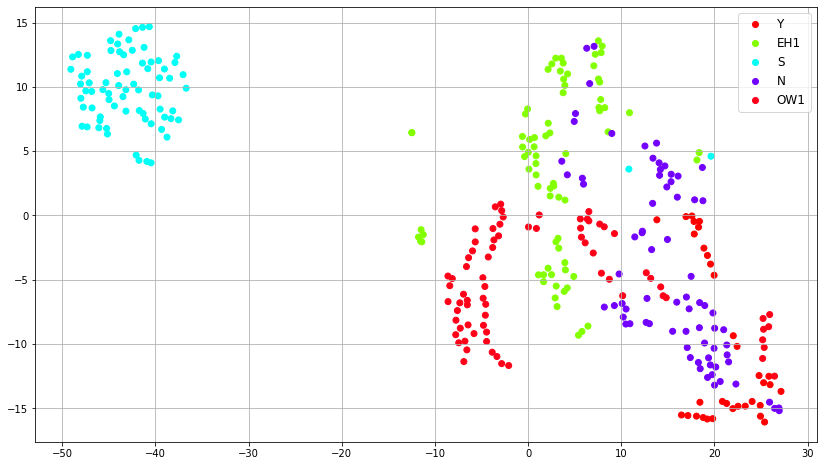

In [ ]:
plt.figure(figsize=(14, 8))
scatter = plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=labels, cmap="hsv")
plt.legend(handles=scatter.legend_elements()[0], labels=phonemes,
           fontsize="large", loc="best")
plt.grid()
plt.show()

### <b>Задание №2</b> (5 баллов):
Заменить модель среднего значения фонемы на GMM. Количестов смесей для каждой фонемы можно выставить в 3. Теперь вместо расстояния мы будем измерять вероятность принадлежности кадра признаков к GMM модели фонемы, находящейся в конкретном узле графа. Чтобы использовать это значение в парадигме нашего алгоритма, в роле дистанции нам нужно брать значение $-log(x)$, где $x$ — предсказанная вероятность. Тогда чем выше вероятность, тем такая импровизированная дистанция будет меньше. Ссылка на питоновскую реализацию GMM — https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html.

Что стало с качеством распознавания на двух тестах?

In [ ]:
phones_dict = init_phones_dict(phones_file)
train_data_dict = load_data_dict(train_records_dir, count=100)

for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]
    file_ali = ali_dict[file_name]
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])

Early stop at 100th file.


In [ ]:
def load_graph(lexicon_dict, gmm_phones_value):
    start_state = State(GmmAcousticModel(None, None), 0)
    graph = [start_state,]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(GmmAcousticModel(phone, phones_dict[phone]),
                          state_index)
            # Etalon word will now be stored in each node:
            state.current_word = word
            state.next_states.append(state)  # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [ ]:
# YES_NO:
lexicon_file = "data/lexicon_yes_no.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict)
records_data_dict = load_data_dict("data/yes_no/records")

In [ ]:
wer_yes_no_gmm, time_yes_no_gmm = run_recognizer(records_data_dict, graph,
                                                 beam_threshold=100)

Result: yes_39a6b995_nohash_0       ==> YES.
Result: no_4abb2400_nohash_0        ==> NO.
Result: no_ad89eb1e_nohash_0        ==> NO.
Result: no_4394fc7c_nohash_0        ==> NO.
Result: yes_39a12648_nohash_0       ==> YES.
Result: yes_fc94edb0_nohash_0       ==> YES.
Result: yes_ff63ab0b_nohash_0       ==> YES.
Result: no_49af4432_nohash_0        ==> NO.
Result: yes_fe1916ba_nohash_0       ==> YES.
Result: no_41474817_nohash_0        ==> YES.
------------------------------------------------------------
WER is: 10.00%.
Total time is: 2.46 sec.
------------------------------------------------------------


In [ ]:
# DIGITS:
lexicon_file = "data/lexicon_digits.txt"
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict)
records_data_dict = load_data_dict("data/digits/records")

In [ ]:
wer_digits_gmm, time_digits_gmm = run_recognizer(records_data_dict, graph,
                                                 beam_threshold=100)

Result: nine_fbe51750_nohash_0      ==> NINE.
Result: seven_fe5c4a7a_nohash_0     ==> SEVEN.
Result: four_ffbb695d_nohash_0      ==> FOUR.
Result: two_fce65496_nohash_0       ==> SIX.
Result: seven_fd32732a_nohash_0     ==> SIX.
Result: one_fc2411fe_nohash_0       ==> NINE.
Result: eight_daf230ac_nohash_0     ==> SIX.
Result: three_feb1d305_nohash_0     ==> SIX.
Result: five_f852895b_nohash_0      ==> FIVE.
Result: zero_f92e49f3_nohash_3      ==> ZERO.
Result: eight_da584bc0_nohash_4     ==> EIGHT.
Result: nine_ccea893d_nohash_0      ==> NINE.
Result: five_ffd2ba2f_nohash_0      ==> FIVE.
Result: two_fb2f3242_nohash_0       ==> TWO.
Result: one_ffa76c4a_nohash_0       ==> ONE.
Result: four_fce65496_nohash_0      ==> FOUR.
Result: six_ffd2ba2f_nohash_0       ==> SIX.
Result: three_fce96bac_nohash_0     ==> SIX.
Result: six_ffbb695d_nohash_0       ==> SIX.
Result: zero_f852895b_nohash_0      ==> FIVE.
------------------------------------------------------------
WER is: 35.00%.
Total time

In [ ]:
print(f"WER for YES_NO improved by {wer_yes_no_mean - wer_yes_no_gmm:.2f}%.")
print(f"Time for YES_NO increased by " \
      f"{time_yes_no_gmm / time_yes_no_mean:.1f} times.")

print(f"WER for DIGITS improved by {wer_digits_mean - wer_digits_gmm:.2f}%.")
print(f"Time for DIGITS increased by " \
      f"{time_digits_gmm / time_digits_mean:.1f} times.")

WER for YES_NO improved by 10.00%.
Time for YES_NO increased by 29.2 times.
WER for DIGITS improved by 20.00%.
Time for DIGITS increased by 59.6 times.
